Code included for option:
* 1947, 1977/1979 mixed, 2015 based intervals

In [1]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import geoutils as gu
import xdem
from pprint import pprint
import altair as alt
from rasterio.enums import Resampling
import json 
import seaborn as sns
import glob

In [2]:
gully_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/gully.shp'
mwasting_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/mass_wasting.shp'
debutressing_data = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/debutressing.shp'

In [3]:
dem_fn_list1 = [
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14.tif",
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1977_09_27_clipped.tif",
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/2015_09_01.tif"
]

dem_fn_list2 = [
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14.tif",
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1979_10_06_clipped.tif",
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/2015_09_01.tif"
]

valley_list1 = ['Park','Rainbow']
valley_list2 = ['Deming', 'Boulder', 'Squak', 'Thunder', 
       'Talum', 'Easton', 'Coleman', 'Mazama']

timestamps1 = ['1947_09_14', '1977_09_27', '2015_09_01']
timestamps2 = ['1947_09_14', '1979_10_06', '2015_09_01']

areas1 = ["rainbow", "park"]

glacier_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/*/glaciers.geojson")

dods_output_path = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dods/"

strip_time_format = "%Y_%m_%d"
reference_dem_date = "2015_09_01"
reference_dem_date = datetime.strptime(
    reference_dem_date, 
    strip_time_format
)

uncertainty_file = "outputs/uncertainty_wholemountain.pcl"

FILTER_OUTLIERS = True
SIMPLE_FILTER = True
simple_filter_threshold = 50
MASK_EXTRA_SIGNALS = False
INTERPOLATE = True
interpolation_max_search_distance = 50

RESAMPLING_RES = 2

SAVE_DDEMS = True

In [4]:
datetimes1 = [datetime.strptime(f, strip_time_format) for f in timestamps1]
datetimes2 = [datetime.strptime(f, strip_time_format) for f in timestamps2]

In [5]:
uncertainty_df = pd.read_pickle(uncertainty_file)
uncertainty_df.head()

,Range,Sill,Interval,NMAD,Mean,Median,RMSE,StdDev,Max,Min,...,Outlier upper limit,pre-filter,Percentage all pixels filtered/removed,Percentage stable pixels filtered/removed,Start Date,End Date,90% CI,90% CI Lower Bound,90% CI Upper Bound,bounding
0,70.469019,3.118267,"(1947-09-14, 1977-09-27]",1.882388,-1.149181,-1.033936,2.364031,2.065921,12.498657,-24.892944,...,50,"{'NMAD': 1.8823880126953123, 'Mean': -1.149180...",0.07681,0.0,1947-09-14,1977-09-27,"(-4.547318804885021, 2.2489575034629)",-4.547319,2.248958,False
1,86.834360,0.104733,"(1977-09-27, 2015-09-01]",0.208129,-0.026259,0.002319,0.532693,0.532045,6.870483,-22.000244,...,50,"{'NMAD': 0.208128662109375, 'Mean': -0.0262585...",0.059444,0.0,1977-09-27,2015-09-01,"(-0.9013948666080718, 0.8488778436705352)",-0.901395,0.848878,False
2,78.690273,3.627443,"(1947-09-14, 1979-10-06]",1.892523,0.733565,0.759399,2.288089,2.167309,44.428101,-49.221313,...,50,"{'NMAD': 1.8939708251953125, 'Mean': 0.4885013...",0.013081,0.00055,1947-09-14,1979-10-06,"(-2.831341469840813, 4.298470819549369)",-2.831341,4.298471,False
3,29.872599,0.236325,"(1979-10-06, 2015-09-01]",0.384043,0.060702,0.031128,0.797750,0.795437,40.519287,-26.310547,...,50,"{'NMAD': 0.38404262695312497, 'Mean': 0.060702...",0.010848,0.0,1979-10-06,2015-09-01,"(-1.247674989238863, 1.3690798084293647)",-1.247675,1.369080,False
4,68.552424,3.788789,"(1947-09-14, 2015-09-01]",1.896324,0.493804,0.555664,2.248279,2.193380,45.104126,-49.281494,...,50,"{'NMAD': 1.8974094726562498, 'Mean': 0.2862122...",0.002866,0.000466,1947-09-14,2015-09-01,"(-3.1139852085781032, 4.101594058580391)",-3.113985,4.101594,True


# Create DEMCollection

In [6]:
demcollection1 = xdem.DEMCollection.from_files(
    dem_fn_list1, 
    datetimes1, 
    reference_dem_date, 
    None, 
    RESAMPLING_RES,
    Resampling.cubic
)

demcollection2 = xdem.DEMCollection.from_files(
    dem_fn_list2, 
    datetimes2, 
    reference_dem_date, 
    None, 
    RESAMPLING_RES,
    Resampling.cubic
)

bounding_demcollection = xdem.DEMCollection.from_files(
    [dem_fn_list1[0], dem_fn_list1[-1]], 
    [datetimes1[0], datetimes1[-1]], 
    reference_dem_date, 
    None, 
    RESAMPLING_RES,
    Resampling.cubic
)

# Open glacier polygons

In [7]:
all_glacier_files = glacier_files
all_glacier_files

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/glaciers.geojson',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/glaciers.geojson',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/glaciers.geojson',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/easton/glaciers.geojson',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/glaciers.geojson',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/glaciers.geojson']

In [8]:
glaciers_gdf = pd.concat([gpd.read_file(f) for f in all_glacier_files])
glaciers_gdf = glaciers_gdf[glaciers_gdf.year.isin(timestamps1 + timestamps2)]
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: datetime.strptime(x, strip_time_format))
glaciers_gdf = glaciers_gdf.to_crs(demcollection1.dems[0].crs)

In [10]:
glaciers_gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Zmin,Zmax,...,Form,TermType,Surging,Linkages,Name,year,area,label,geometry,date
1,RGI60-02.17738,G238159E48761N,19759999,-9999999,-121.84148,48.76089,2,4,1192.0,3269.0,...,0.0,0.0,0.0,9.0,Deming Glacier WA,1977_09_27,NaN,NaN,"MULTIPOLYGON (((584486.911 5400385.518, 584484...",1977-09-27
2,RGI60-02.17738,G238159E48761N,19759999,-9999999,-121.84148,48.76089,2,4,1192.0,3269.0,...,0.0,0.0,0.0,9.0,Deming Glacier WA,1979_10_06,NaN,NaN,"MULTIPOLYGON (((584817.083 5400288.237, 584814...",1979-10-06
6,RGI60-02.17738,G238159E48761N,19759999,-9999999,-121.84148,48.76089,2,4,1192.0,3269.0,...,0.0,0.0,0.0,9.0,Deming Glacier WA,2015_09_01,1176.0,Deming Glacier,"MULTIPOLYGON (((584463.003 5400368.431, 584472...",2015-09-01
8,RGI60-02.17738,G238159E48761N,19759999,-9999999,-121.84148,48.76089,2,4,1192.0,3269.0,...,0.0,0.0,0.0,9.0,Deming Glacier WA,1947_09_14,1246.0,NaN,"MULTIPOLYGON (((584815.932 5400295.913, 584791...",1947-09-14
5,RGI60-02.17268,G238238E48784N,19759999,-9999999,-121.76169,48.78371,2,4,1671.0,1717.0,...,0.0,0.0,0.0,9.0,WA,1977_09_27,NaN,NaN,"MULTIPOLYGON (((590896.477 5404216.479, 590908...",1977-09-27


In [11]:
glaciers_gdf.year.unique(), glaciers_gdf.date.unique()

(array(['1977_09_27', '1979_10_06', '2015_09_01', '1947_09_14'],
       dtype=object),
 array(['1977-09-27T00:00:00.000000000', '1979-10-06T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '1947-09-14T00:00:00.000000000'],
       dtype='datetime64[ns]'))

<Axes: >

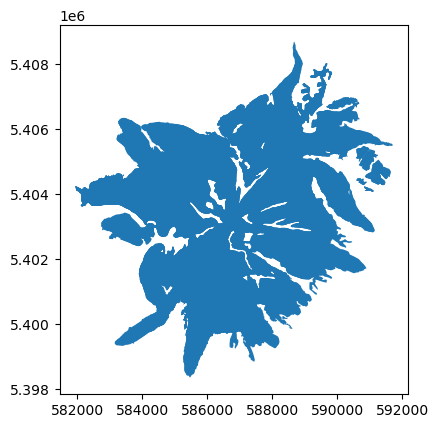

In [12]:
glaciers_gdf.plot()

In [13]:
glaciers_gdf = glaciers_gdf.dropna(subset=['geometry'])

# Subtract DEMs/Create DoDs

In [14]:
_ = demcollection1.subtract_dems_intervalwise()
_ = demcollection2.subtract_dems_intervalwise()
_ = bounding_demcollection.subtract_dems_intervalwise()

# Filter outliers

In [15]:
if FILTER_OUTLIERS:
    for dh in demcollection1.ddems + demcollection2.ddems + bounding_demcollection.ddems:
        if SIMPLE_FILTER:
            dh.data = np.ma.masked_where(np.abs(dh.data) > simple_filter_threshold, dh.data)
        else:
            all_values_masked = dh.data.copy()
            all_values = all_values_masked.filled(np.nan)
            low = np.nanmedian(all_values) - 4*xdem.spatialstats.nmad(all_values)
            high = np.nanmedian(all_values) + 4*xdem.spatialstats.nmad(all_values)
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print(dh.interval)
            print(low)
            print(high)
            all_values_masked = np.ma.masked_greater(all_values_masked, high)
            all_values_masked = np.ma.masked_less(all_values_masked, low)
            dh.data = all_values_masked
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print()


# Interpolate

In [19]:
if INTERPOLATE:
    _ = demcollection1.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcollection1.set_ddem_filled_data()

    _ = demcollection2.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcollection2.set_ddem_filled_data()

    _ = bounding_demcollection.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    bounding_demcollection.set_ddem_filled_data()

# Mask Glacier Signals

In [20]:
for ddem in demcollection1.ddems + demcollection2.ddems + bounding_demcollection.ddems:
    relevant_glaciers_gdf = glaciers_gdf[glaciers_gdf['date'].isin([ddem.interval.left, ddem.interval.right])]
    relevant_glaciers_mask = gu.Vector(relevant_glaciers_gdf).create_mask(ddem).squeeze()
    ddem.data.mask = np.logical_or(ddem.data.mask, relevant_glaciers_mask)

# Prepare erosion polygons

### Load all erosion polygons

In [21]:
all_erosion_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/*/erosion.geojson")
hillslope_fluvial_erosion_vector = gu.Vector(gpd.GeoDataFrame(pd.concat([gpd.read_file(f) for f in all_erosion_files])))

erosion_vector = gu.Vector(
    pd.concat([
        gu.Vector(gully_data).ds,
        gu.Vector(mwasting_data).ds,
        gu.Vector(debutressing_data).ds,
        hillslope_fluvial_erosion_vector.ds
    ])
)

<Axes: >

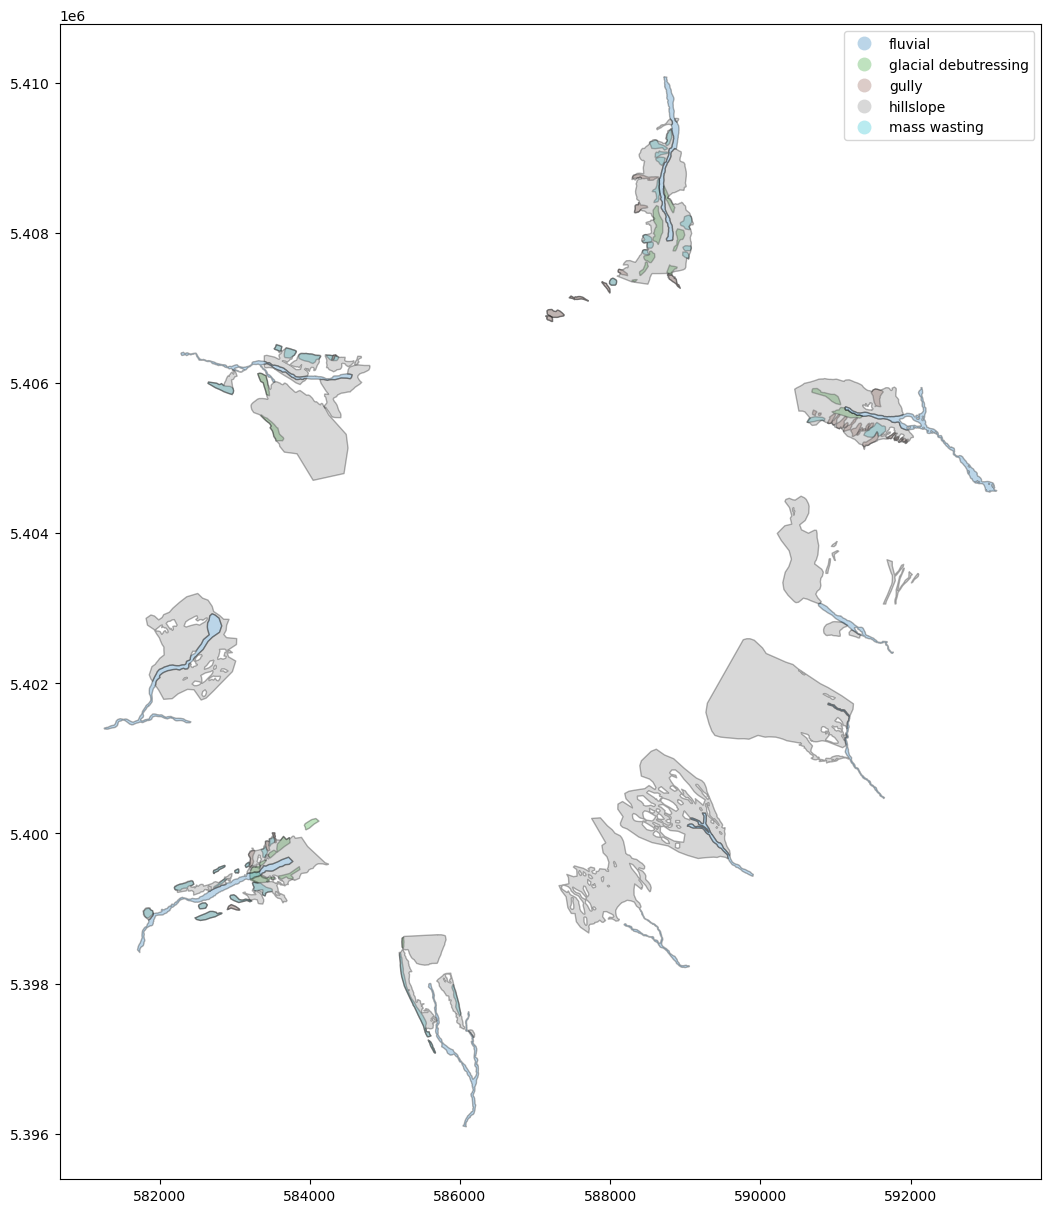

In [22]:
erosion_vector.ds.plot(edgecolor='black', alpha=0.3, column='type', figsize=(15,15), legend=True)

### Subtract glacier polygons from erosion polygons

For each dDEM time interval, get the two relevant glacier polygons, and subtract them from each erosion polygon, so that each erosion polygon multiplies to become one erosion polygon per time interval

In [23]:
new_erosion_gdf = gpd.GeoDataFrame()

def subtract_multiple_geoms(polygon, cutting_geometries):
        new_polygon = polygon
        for cutting_geom in cutting_geometries:
            new_polygon = new_polygon.difference(cutting_geom)
        return new_polygon

for ddem in demcollection1.ddems:
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
    local_erosion_vector = erosion_vector.ds[erosion_vector.ds['name'].isin(valley_list1)]
    differenced_geoms = local_erosion_vector.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf = pd.concat([
        new_erosion_gdf,
        gpd.GeoDataFrame({
            'geometry': differenced_geoms,
            'type': local_erosion_vector['type'],
            'interval': np.full(len(differenced_geoms), ddem.interval),
            'name': local_erosion_vector['name']
        })
    ])

for ddem in demcollection2.ddems:
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
    local_erosion_vector = erosion_vector.ds[erosion_vector.ds['name'].isin(valley_list2)]
    differenced_geoms = local_erosion_vector.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf = pd.concat([
        new_erosion_gdf,
        gpd.GeoDataFrame({
            'geometry': differenced_geoms,
            'type': local_erosion_vector['type'],
            'interval': np.full(len(differenced_geoms), ddem.interval),
            'name': local_erosion_vector['name']
        })
    ])

for ddem in bounding_demcollection.ddems:
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
    differenced_geoms = erosion_vector.ds.geometry.apply(
        lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf = pd.concat([
        new_erosion_gdf,
        gpd.GeoDataFrame({
            'geometry': differenced_geoms,
            'type': erosion_vector.ds['type'],
            'interval': np.full(len(differenced_geoms), ddem.interval),
            'name': erosion_vector.ds['name']
        })
    ])

### Create outlines dictionaries for each demcollection

In [24]:
def get_ddem_intervals(demcollection):
    return [ddem.interval for ddem in demcollection.ddems]
    
# separate into different Vector objects
normal_erosion_vector_ds1 = new_erosion_gdf[new_erosion_gdf.interval.isin(get_ddem_intervals(demcollection1))]
normal_erosion_vector_ds2 = new_erosion_gdf[new_erosion_gdf.interval.isin(get_ddem_intervals(demcollection2))]
bounding_erosion_vector_ds = new_erosion_gdf[new_erosion_gdf.interval.isin(get_ddem_intervals(bounding_demcollection))]

# Create dictionaries from GDFs, with intervals as keys
demcollection1.outlines = {k:gu.Vector(gdf) for k, gdf in dict(list(normal_erosion_vector_ds1.groupby("interval"))).items()}
demcollection2.outlines = {k:gu.Vector(gdf) for k, gdf in dict(list(normal_erosion_vector_ds2.groupby("interval"))).items()}
bounding_demcollection.outlines = {k:gu.Vector(gdf) for k, gdf in dict(list(bounding_erosion_vector_ds.groupby("interval"))).items()}

#### Plot erosion geoms by date

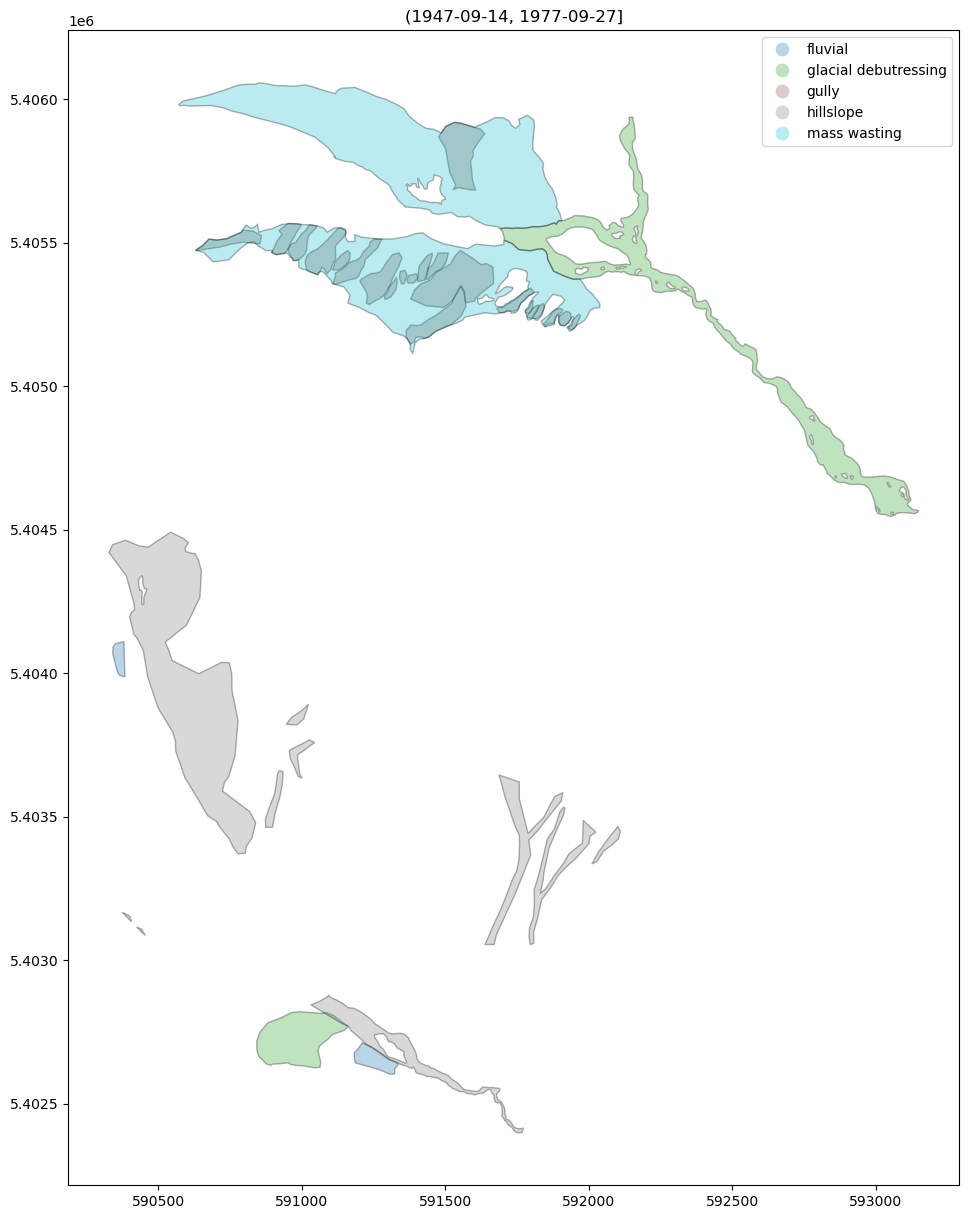

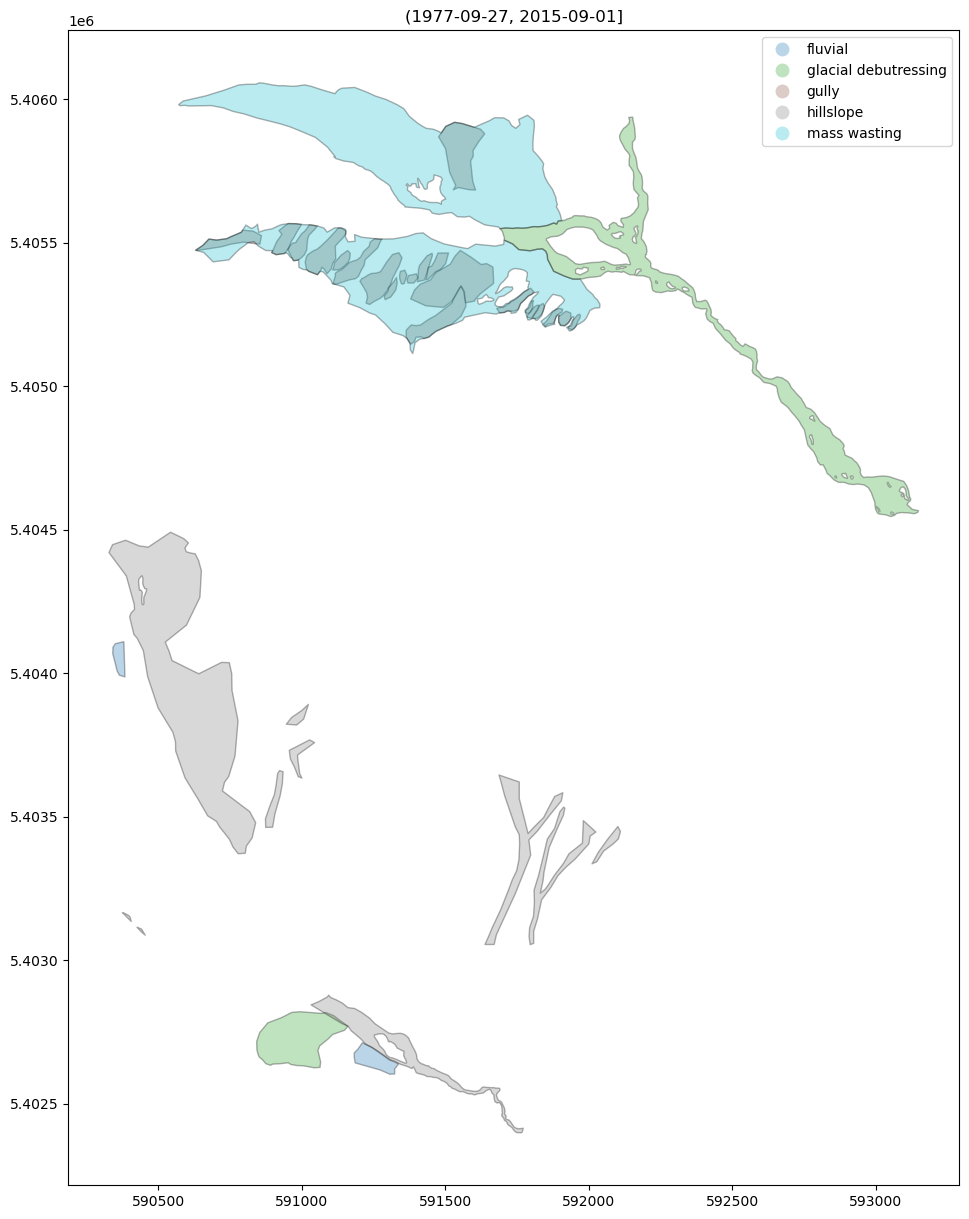

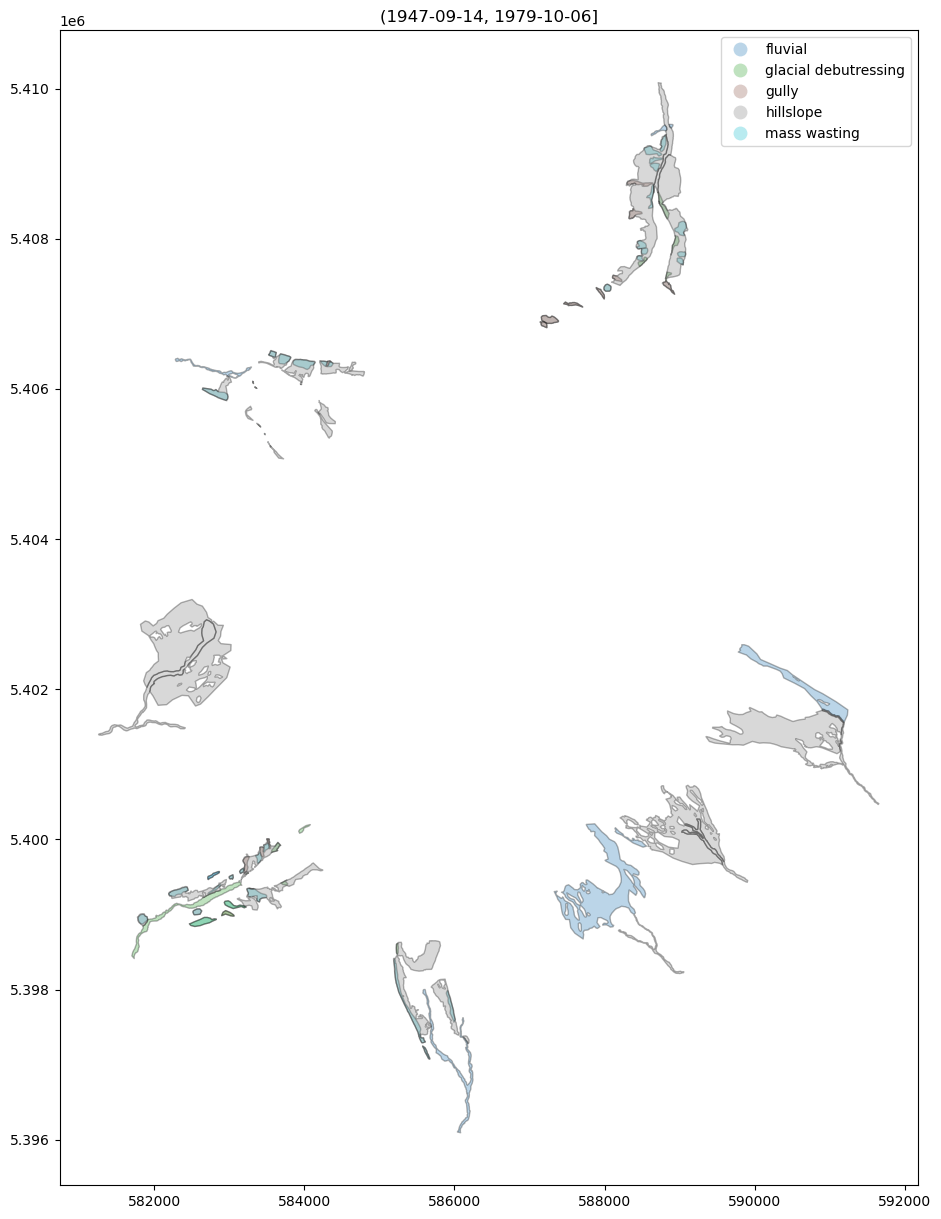

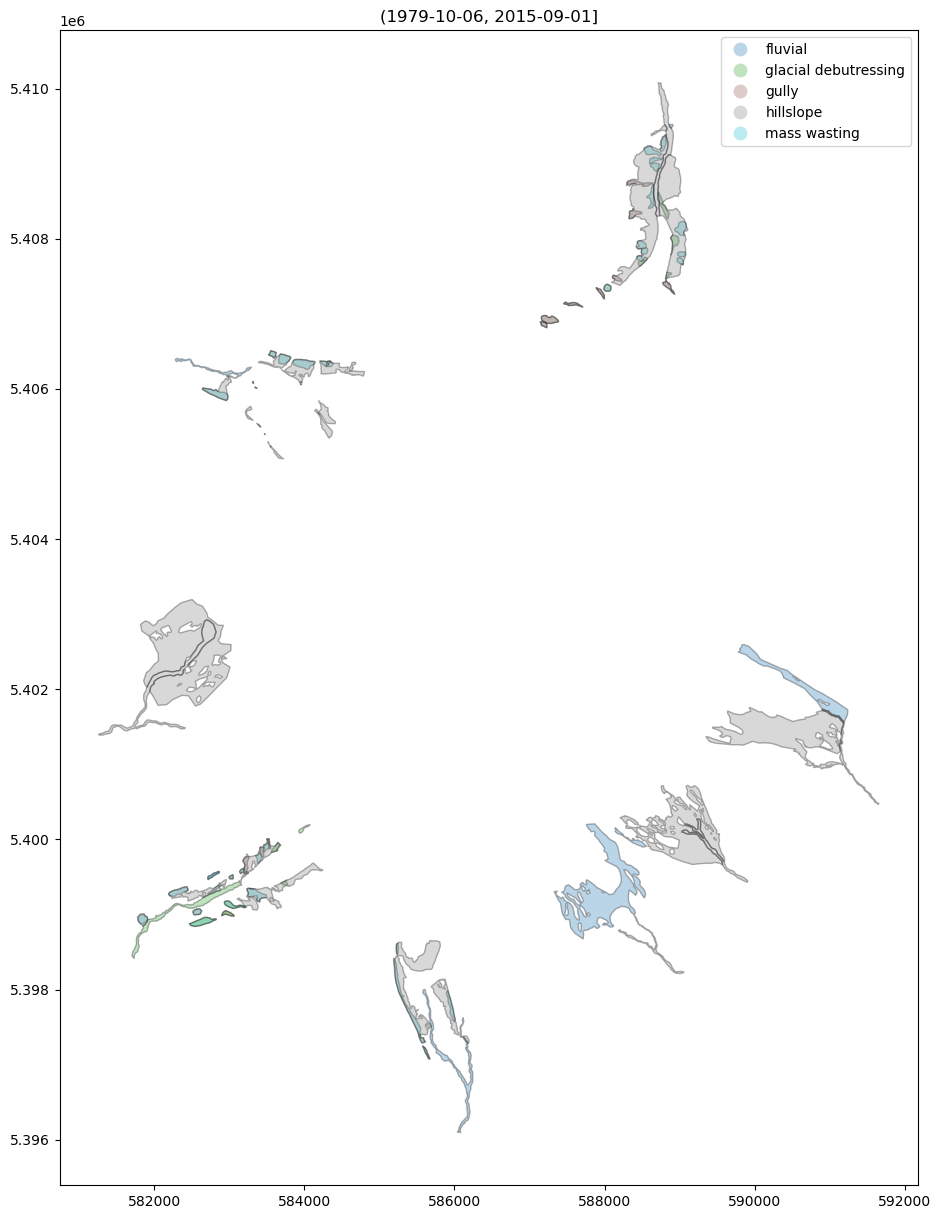

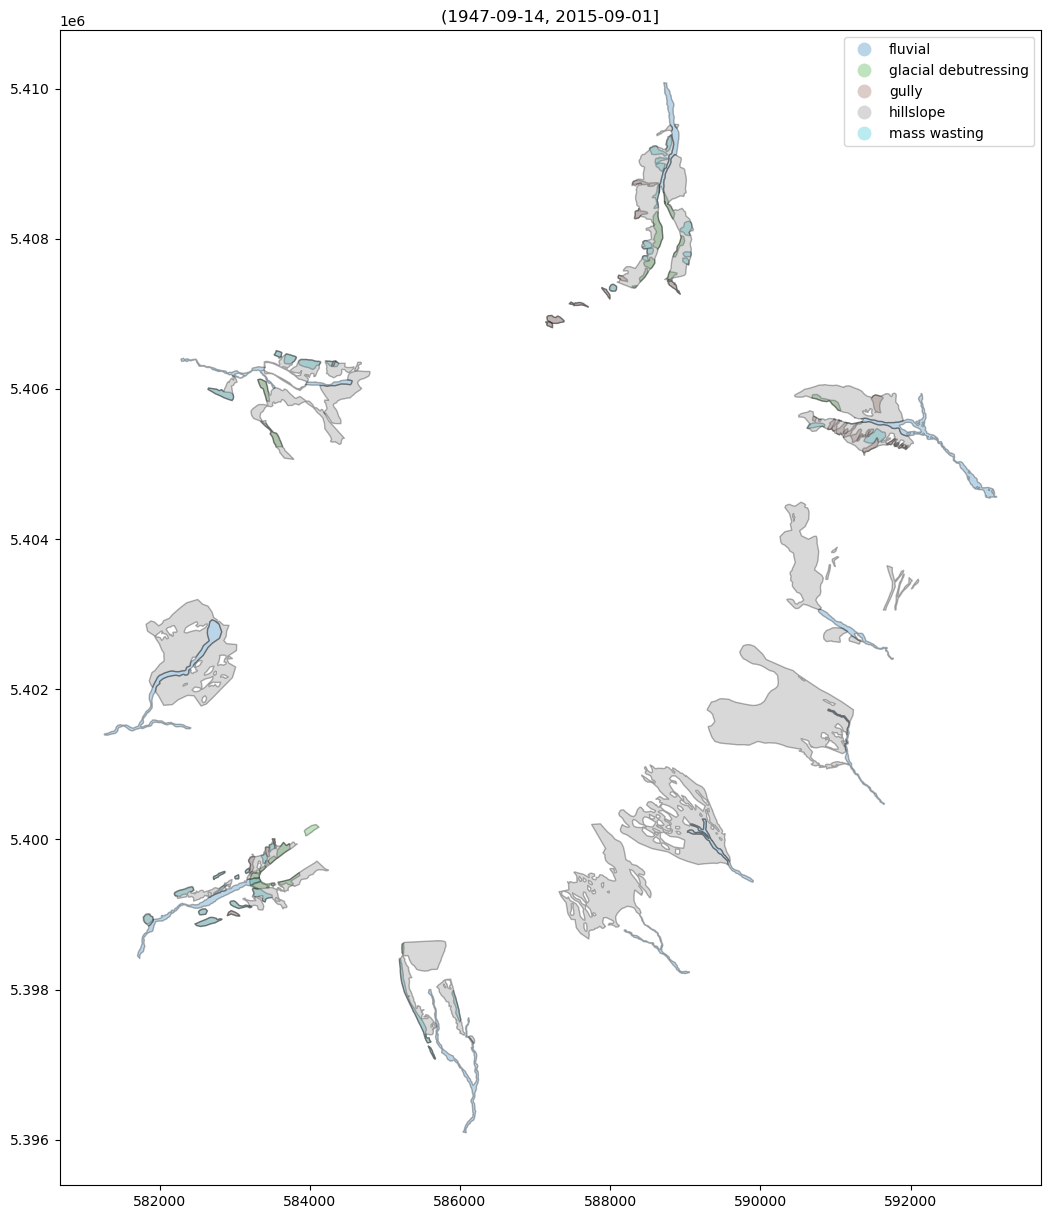

In [25]:
for tup in demcollection1.outlines.items():
    interval = tup[0]
    gdf = tup[1].ds
    gdf.plot(edgecolor='black', alpha=0.3, column='type', figsize=(15,15), legend=True)
    plt.gca().set_title(str(interval))
    plt.show()

for tup in demcollection2.outlines.items():
    interval = tup[0]
    gdf = tup[1].ds
    gdf.plot(edgecolor='black', alpha=0.3, column='type', figsize=(15,15), legend=True)
    plt.gca().set_title(str(interval))
    plt.show()

for tup in bounding_demcollection.outlines.items():
    interval = tup[0]
    gdf = tup[1].ds
    gdf.plot(edgecolor='black', alpha=0.3, column='type', figsize=(15,15), legend=True)
    plt.gca().set_title(str(interval))
    plt.show()

In [26]:
if MASK_EXTRA_SIGNALS:
    for ddem in demcollection1.ddems + demcollection2.ddems + bounding_demcollection.ddems:
        local_erosion_vector = erosion_vector.copy()
        local_erosion_vector.ds = local_erosion_vector.ds[local_erosion_vector.ds['interval'] == ddem.interval]
        extra_signals_mask = ~local_erosion_vector.create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, extra_signals_mask)

In [ ]:
for ddem in demcollection1.ddems + demcollection2.ddems + bounding_demcollection.ddems:
    sns.distplot(ddem.data.filled(np.nan))
    plt.title(str(ddem.interval))
    plt.show()

In [ ]:
demcollection1.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")

In [ ]:
demcollection2.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")

In [ ]:
bounding_demcollection.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")

In [ ]:
if SAVE_DDEMS:
    # Save all interval dDEMs
    os.makedirs(dods_output_path, exist_ok=True)

    for ddem in demcollection1.ddems + demcollection2.ddems + bounding_demcollection.ddems:
        startt = ddem.start_time.strftime(strip_time_format)
        endt = ddem.end_time.strftime(strip_time_format)
        fn = f"{startt}_to_{endt}.tif"
        fn = os.path.join(dods_output_path, fn)
        print(fn)
        ddem_xr = ddem.to_xarray()
        ddem_xr.data = ddem.data.filled(np.nan)
        ddem_xr.rio.to_raster(fn)

### Define functions to threshold and create pos/neg DEMCollections
* Make sure to set values equal to 0 instead of actually removing them!!

In [28]:
from scipy import stats
def threshold_ddem(ddem):
    ddem = ddem.copy()
    sample = ddem.data.compressed()
    datum = uncertainty_df.loc[uncertainty_df['Interval'] == ddem.interval]
    assert len(datum) == 1
    low = datum['90% CI Lower Bound'].iloc[0]
    hi = datum['90% CI Upper Bound'].iloc[0]
    print((low, hi))
    ddem.data[
        np.logical_and(ddem.data>low, ddem.data<hi)
    ] = 0
    
    return ddem

def create_thresholded_demcollection(old_demcollection):
    threshold_demcollection = xdem.DEMCollection(
        old_demcollection.dems,
        old_demcollection.timestamps
    )
    threshold_demcollection.ddems_are_intervalwise = True
    threshold_demcollection.ddems = [threshold_ddem(ddem) for ddem in old_demcollection.ddems]
    threshold_demcollection.outlines = old_demcollection.outlines
    return threshold_demcollection

def create_positive_and_negative_ddems(ddem):
    pos = ddem.copy()
    neg = ddem.copy()
    pos.data = np.ma.masked_less(pos.data, 0)
    neg.data = np.ma.masked_greater(neg.data, 0)
    return pos, neg

def create_positive_and_negative_demcollection(demcollection):
    pos_ddems, neg_ddems = zip(*[create_positive_and_negative_ddems(ddem) for ddem in demcollection.ddems])
    pos_ddemcollection = xdem.DEMCollection(
        demcollection.dems,
        demcollection.timestamps
    )
    pos_ddemcollection.ddems_are_intervalwise = True
    pos_ddemcollection.ddems = pos_ddems
    pos_ddemcollection.outlines = demcollection.outlines

    neg_ddemcollection = xdem.DEMCollection(
        demcollection.dems,
        demcollection.timestamps
    )
    neg_ddemcollection.ddems_are_intervalwise = True
    neg_ddemcollection.ddems = neg_ddems
    neg_ddemcollection.outlines = demcollection.outlines

    return pos_ddemcollection, neg_ddemcollection

### Create thresholded DEM collections

In [29]:
pos_demcollection1, neg_demcollection1 = create_positive_and_negative_demcollection(create_thresholded_demcollection(demcollection1))
pos_demcollection2, neg_demcollection2 = create_positive_and_negative_demcollection(create_thresholded_demcollection(demcollection2))
pos_bounding_demcollection, neg_bounding_demcollection = create_positive_and_negative_demcollection(create_thresholded_demcollection(bounding_demcollection))

(-4.547318804885021, 2.2489575034629)
(-0.9013948666080718, 0.8488778436705352)
(-2.831341469840813, 4.298470819549369)
(-1.247674989238863, 1.3690798084293647)
(-3.1139852085781032, 4.101594058580391)


# Mass wasting calculations - not differentiated by process (ie use hillslope + fluvial polygons)

## Calculate Net mass wasted by valley

Loop through the two demcollections with the two valley lists.

In [30]:
def get_hillslope_and_fluvial_filter(name):
    return f"name == '{name}' and (type == 'hillslope' or type == 'fluvial')"

dv_df_by_valley = pd.DataFrame()
for name in valley_list1:
    results_df = demcollection1.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    results_df['bounding'] = False
    bounding_results_df = bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    bounding_results_df['bounding'] = True
    new_df = pd.concat([results_df, bounding_results_df])
    new_df['name'] = name
    dv_df_by_valley = dv_df_by_valley.append(new_df)

for name in valley_list2:
    results_df = demcollection2.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    results_df['bounding'] = False
    bounding_results_df = bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    bounding_results_df['bounding'] = True
    new_df = pd.concat([results_df, bounding_results_df])
    new_df['name'] = name
    dv_df_by_valley = dv_df_by_valley.append(new_df)


/tmp/ipykernel_310462/1502014552.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dv_df_by_valley = dv_df_by_valley.append(new_df)
/tmp/ipykernel_310462/1502014552.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dv_df_by_valley = dv_df_by_valley.append(new_df)
/tmp/ipykernel_310462/1502014552.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dv_df_by_valley = dv_df_by_valley.append(new_df)
/tmp/ipykernel_310462/1502014552.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dv_df_by_valley = dv_df_by_valley.append(new_df)
/tmp/ipykernel_310462/1502014552.py:21: FutureWarning: The frame.append method is deprecated and will be

## Calculate Gross mass wasted by valley

In [31]:
thresh_pos_dv_df_by_valley = pd.DataFrame()
thresh_neg_dv_df_by_valley = pd.DataFrame()

for name in valley_list1:
    pos_results_df = pos_demcollection1.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    pos_results_df['bounding'] = False
    pos_bounding_results_df = pos_bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    pos_bounding_results_df['bounding'] = True
    new_df = pd.concat([pos_results_df, pos_bounding_results_df])
    new_df['name'] = name
    thresh_pos_dv_df_by_valley = thresh_pos_dv_df_by_valley.append(new_df)

    neg_results_df = neg_demcollection1.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    neg_results_df['bounding'] = False
    neg_bounding_results_df = neg_bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    neg_bounding_results_df['bounding'] = True
    new_df = pd.concat([neg_results_df, neg_bounding_results_df])
    new_df['name'] = name
    thresh_neg_dv_df_by_valley = thresh_neg_dv_df_by_valley.append(new_df)

for name in valley_list2:
    pos_results_df = pos_demcollection2.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    pos_results_df['bounding'] = False
    pos_bounding_results_df = pos_bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    pos_bounding_results_df['bounding'] = True
    new_df = pd.concat([pos_results_df, pos_bounding_results_df])
    new_df['name'] = name
    thresh_pos_dv_df_by_valley = thresh_pos_dv_df_by_valley.append(new_df)

    neg_results_df = neg_demcollection2.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    neg_results_df['bounding'] = False
    neg_bounding_results_df = neg_bounding_demcollection.get_dv_series(return_area=True, outlines_filter=get_hillslope_and_fluvial_filter(name)).reset_index()
    neg_bounding_results_df['bounding'] = True
    new_df = pd.concat([neg_results_df, neg_bounding_results_df])
    new_df['name'] = name
    thresh_neg_dv_df_by_valley = thresh_neg_dv_df_by_valley.append(new_df)

/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2525938797.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thresh_pos_dv_df_by_valley = thresh_pos_dv_df_by_valley.append(new_df)
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs f

In [32]:
def enrich_volume_data(df, pixel_area, pixel_side_length, uncertainty_df):
    """Modify the resulting dataframe of `demcollection.get_dv_series` by 
    adding a bunch of useful data. Calculates volumetric uncertainty as well.

    Args:
        df (_type_): _description_
        pixel_area (_type_): _description_
    """
    df["n_pixels"] = df["area"]/pixel_area

    df["volumetric_uncertainty"] = df.apply(
        lambda row: xdem.spatialstats.volumetric_uncertainty(
            n_pixels = row["n_pixels"],
            pixel_side_length = pixel_side_length,
            rmse = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['RMSE'].iloc[0],
            mean = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Mean'].iloc[0],
            range_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Range'].iloc[0],
            sill_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Sill'].iloc[0],
        ),
        axis=1
    )
    df['start_time'] = df['index'].apply(lambda x: x.left)
    df['end_time'] = df['index'].apply(lambda x: x.right)
    df['time_difference_years'] = df.apply(
        lambda row: round((row['end_time'] - row['start_time']).days/365.25),
        axis=1
    )
    df['Annual Mass Wasted'] = df['volume']/df['time_difference_years']
    df["Upper CI"] = (df['volume'] + df['volumetric_uncertainty'])/df['time_difference_years']
    df["Lower CI"] = (df['volume'] - df['volumetric_uncertainty'])/df['time_difference_years']
    df["Average Date"] = df['start_time'] + ((df['end_time'] - df['start_time']) / 2).dt.ceil('D')
    return df

In [33]:
dv_df_by_valley = enrich_volume_data(
    dv_df_by_valley,
    pixel_area = demcollection1.reference_dem.res[0] * demcollection1.reference_dem.res[1],
    pixel_side_length = demcollection1.reference_dem.res[0],
    uncertainty_df=uncertainty_df
)
thresh_pos_dv_df_by_valley = enrich_volume_data(
    thresh_pos_dv_df_by_valley,
    pixel_area = demcollection1.reference_dem.res[0] * demcollection1.reference_dem.res[1],
    pixel_side_length = demcollection1.reference_dem.res[0],
    uncertainty_df=uncertainty_df
)
thresh_neg_dv_df_by_valley = enrich_volume_data(
    thresh_neg_dv_df_by_valley,
    pixel_area = demcollection1.reference_dem.res[0] * demcollection1.reference_dem.res[1],
    pixel_side_length = demcollection1.reference_dem.res[0],
    uncertainty_df=uncertainty_df
)

## Plot

### Plotting Convenience Functions

In [34]:
valley_sorting = [
            'Mazama',
            'Deming',
            'Coleman',
            'Rainbow',
            'Park',
            'Easton',
            'Squak',
            'Talum',
            'Boulder',
            'Thunder'
        ]

def get_bars(df, color=None, value="Annual Mass Wasted:Q", x_axis = 'name:O'):
    if color:
        bars_mark = alt.Chart(df).mark_bar(
            strokeWidth = 1.5,
            stroke="white",
            color=color,
            opacity=0.8
        )
    else:
        bars_mark = alt.Chart(df).mark_bar(
            strokeWidth = 1.5,
            stroke="white",
            opacity=0.8
        )
    bars = bars_mark.encode(
        alt.X(x_axis, sort=valley_sorting),
        alt.Y(value)
    ).properties(
        # width=300, 
        # height=300
    )
    return bars 
def bars_and_error_bars(df, color=None, value="Annual Mass Wasted:Q", bars_2_cols = ["Lower CI", "Upper CI"], x_axis = 'name:O', 
    x_title = 'Valley', y_title = "Annualized rate of volumetric change, in m³/yr"
):
    bars = get_bars(df, color, value, x_axis)
    error_bars = alt.Chart(df).mark_bar(
        color="black",
        width=2
    ).encode(
        alt.X(x_axis, sort=valley_sorting, title=x_title),
        alt.Y(bars_2_cols[0], title=y_title),
        alt.Y2(bars_2_cols[1])
    )
    return (bars + error_bars)

### Net mass wasted 

In [35]:
src = dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(bounding)
early_chart = bars_and_error_bars(non_bounding[non_bounding.start_time == datetime(1947, 9, 14)])
late_chart = bars_and_error_bars(non_bounding[non_bounding.end_time == datetime(2015, 9, 1)])

(
    bounding_chart.properties(title="1947-2015") | early_chart.properties(title="1947-1977/79 ") | late_chart.properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

### Gross mass wasted

In [36]:
src_neg = thresh_neg_dv_df_by_valley.drop(columns='index')
bounding_neg = src_neg[src_neg.bounding==True]
non_bounding_neg = src_neg[src_neg.bounding==False]

bounding_chart_neg = bars_and_error_bars(bounding_neg)
early_chart_neg = bars_and_error_bars(non_bounding_neg[non_bounding_neg.start_time == datetime(1947, 9, 14)])
late_chart_neg = bars_and_error_bars(non_bounding_neg[non_bounding_neg.end_time == datetime(2015, 9, 1)])

src_pos = thresh_pos_dv_df_by_valley.drop(columns='index')
bounding_pos = src_pos[src_pos.bounding==True]
non_bounding_pos = src_pos[src_pos.bounding==False]

bounding_chart_pos = bars_and_error_bars(bounding_pos, color='red')
early_chart_pos = bars_and_error_bars(non_bounding_pos[non_bounding_pos.start_time == datetime(1947, 9, 14)], color='red')
late_chart_pos = bars_and_error_bars(non_bounding_pos[non_bounding_pos.end_time == datetime(2015, 9, 1)], color='red')

(
    (bounding_chart_neg + bounding_chart_pos).properties(title="1947-2015") | 
    (early_chart_neg + early_chart_pos).properties(title="1947-1977/79 ") | 
    (late_chart_neg + late_chart_pos).properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Gross erosion and deposition')


alt.HConcatChart(...)

## Incision Rate

### Based on net erosion, by valley

In [37]:
dv_df_by_valley['Annual Incision Rate'] = dv_df_by_valley['Annual Mass Wasted']/dv_df_by_valley['area']
dv_df_by_valley['Incision Lower CI'] = dv_df_by_valley['Lower CI']/dv_df_by_valley['area']
dv_df_by_valley['Incision Upper CI'] = dv_df_by_valley['Upper CI']/dv_df_by_valley['area']

In [38]:
src = dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(
    bounding, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)
early_chart = bars_and_error_bars(
    non_bounding[non_bounding.start_time == datetime(1947, 9, 14)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)
late_chart = bars_and_error_bars(
    non_bounding[non_bounding.end_time == datetime(2015, 9, 1)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)

(
    bounding_chart.properties(title="1947-2015") | early_chart.properties(title="1947-1977/79 ") | late_chart.properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

### Based on gross erosion, by valley

In [39]:
thresh_neg_dv_df_by_valley['Annual Incision Rate'] = thresh_neg_dv_df_by_valley['Annual Mass Wasted']/thresh_neg_dv_df_by_valley['area']
thresh_neg_dv_df_by_valley['Incision Lower CI'] = thresh_neg_dv_df_by_valley['Lower CI']/thresh_neg_dv_df_by_valley['area']
thresh_neg_dv_df_by_valley['Incision Upper CI'] = thresh_neg_dv_df_by_valley['Upper CI']/thresh_neg_dv_df_by_valley['area']

In [40]:
src = thresh_neg_dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(
    bounding, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)
early_chart = bars_and_error_bars(
    non_bounding[non_bounding.start_time == datetime(1947, 9, 14)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)
late_chart = bars_and_error_bars(
    non_bounding[non_bounding.end_time == datetime(2015, 9, 1)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    y_title = "Annualized incision rate, in m/yr"
)

(
    bounding_chart.properties(title="1947-2015") | early_chart.properties(title="1947-1977/79 ") | late_chart.properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

# Mass wasting calculations - differentiated by process

## Make calculations, organized by valley and process

In [41]:
process_thresh_neg_dv_df_by_valley = pd.DataFrame()

def get_valley_filter(name):
    return f"name == '{name}'"

unique_processes = erosion_vector.ds['type'].unique()

for name in valley_list1 + valley_list2:
    for process in unique_processes:
        print(name)
        print(process)

        if name in valley_list1:
            neg_demcollection_to_use = neg_demcollection1
        elif name in valley_list2:
            neg_demcollection_to_use = neg_demcollection2
        else:
            raise ValueError("impossible!")
        
        try:
            new_neg_results_df = neg_demcollection_to_use.get_dv_series(
                return_area=True, outlines_filter=f"name == '{name}' and type == '{process}'"
            ).reset_index()
            new_neg_results_df['process'] = process
            new_neg_results_df['bounding'] = False
            new_neg_results_df['name'] = name
        except:
            print('Got exception for {name} {process} but continuing anyways...')
            new_neg_results_df = pd.DataFrame()

        new_bounding_neg_results_df = neg_bounding_demcollection.get_dv_series(
            return_area=True, outlines_filter=f"name == '{name}' and type == '{process}'"
        ).reset_index()
        new_bounding_neg_results_df['process'] = process
        new_bounding_neg_results_df['bounding'] = True
        new_bounding_neg_results_df['name'] = name
        
        process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)

Park
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Park
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Park
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Park
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Park
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Rainbow
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/mambaforge/envs/hsfm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_vall

Rainbow
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Rainbow
glacial debutressing
Got exception for {name} {process} but continuing anyways...


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)


Rainbow
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Rainbow
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1977-09-27 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1977-09-27 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Deming
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Deming
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Deming
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/mambaforge/envs/hsfm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_vall

Deming
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Deming
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Boulder
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Boulder
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Boulder
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Boulder
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Boulder
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Squak
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Squak
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Squak
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Squak
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Squak
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Thunder
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Thunder
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Thunder
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Thunder
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Thunder
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Talum
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Talum
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Talum
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_b

Talum
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Talum
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Easton
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Easton
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Easton
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Easton
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Easton
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Coleman
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Coleman
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Coleman
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Coleman
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Coleman
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Mazama
gully


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Mazama
mass wasting


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Mazama
glacial debutressing


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/mambaforge/envs/hsfm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_vall

Mazama
hillslope


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

Mazama
fluvial


/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 1979-10-06 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:289: UserWarning: NaNs found in dDEM (1947-09-14 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  process_thresh_neg_dv_df_by_valley = process_thresh_neg_dv_df_by_valley.append(new_neg_results_df).append(new_bounding_neg_results_df)
/tmp/ipykernel_310462/2568767260.py:38: FutureWarning: The frame.append method is de

In [42]:
process_thresh_neg_dv_df_by_valley = enrich_volume_data(
    process_thresh_neg_dv_df_by_valley,
    pixel_area = demcollection1.reference_dem.res[0] * demcollection1.reference_dem.res[1],
    pixel_side_length = demcollection1.reference_dem.res[0],
    uncertainty_df=uncertainty_df
)

/home/elilouis/xdem/xdem/spatialstats.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  rmse**2/n_pixels + mean**2 + (
/home/elilouis/xdem/xdem/spatialstats.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  sill_val/n_pixels
/home/elilouis/xdem/xdem/spatialstats.py:58: RuntimeWarning: invalid value encountered in double_scalars
  return n_pixels*(pixel_side_length**2)*np.sqrt(
/home/elilouis/xdem/xdem/spatialstats.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  rmse**2/n_pixels + mean**2 + (
/home/elilouis/xdem/xdem/spatialstats.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  sill_val/n_pixels
/home/elilouis/xdem/xdem/spatialstats.py:58: RuntimeWarning: invalid value encountered in double_scalars
  return n_pixels*(pixel_side_length**2)*np.sqrt(
/home/elilouis/xdem/xdem/spatialstats.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  rmse**2/n_pixels + mean**2 + (
/home/elilouis/xdem/x

In [43]:
process_thresh_neg_dv_df_by_valley.groupby("index").apply(len)

index
(1947-09-14, 1977-09-27]     9
(1947-09-14, 1979-10-06]    40
(1947-09-14, 2015-09-01]    50
(1977-09-27, 2015-09-01]     9
(1979-10-06, 2015-09-01]    40
dtype: int64

## Plot

### Gross erosion by process, by valley

In [44]:

src = process_thresh_neg_dv_df_by_valley[process_thresh_neg_dv_df_by_valley.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
alt.Chart(src.drop(columns='index')).transform_filter(
    alt.datum.bounding==True
).mark_bar().encode(
    alt.X('name:O'),
    alt.Y("volume:Q"),
    alt.Color("process:N")
)

alt.Chart(...)

In [45]:
src = process_thresh_neg_dv_df_by_valley[process_thresh_neg_dv_df_by_valley.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
src['hillslope'] = src['process'] == 'hillslope'
alt.Chart(src.drop(columns='index')).transform_filter(
    alt.datum.bounding==True
).mark_bar().encode(
    alt.X('hillslope:O'),
    alt.Y("Annual Mass Wasted:Q"),
    alt.Facet('name:O'),
    alt.Color("process:N")
)

/tmp/ipykernel_310462/1177735981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['hillslope'] = src['process'] == 'hillslope'


alt.Chart(...)

In [46]:
src = process_thresh_neg_dv_df_by_valley[process_thresh_neg_dv_df_by_valley.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
alt.Chart(src.drop(columns='index')).transform_filter(alt.datum.bounding==True).mark_bar().encode(
    alt.X('process:O'),
    alt.Y("volume:Q"),
    alt.Facet("name:O")
)

alt.Chart(...)

In [47]:
src = process_thresh_neg_dv_df_by_valley[process_thresh_neg_dv_df_by_valley.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
src = src[src.process != 'hillslope']
alt.Chart(src.drop(columns='index')).transform_filter(alt.datum.bounding==True).mark_bar().encode(
    alt.X('process:O'),
    alt.Y("volume:Q"),
    alt.Facet("name:O")
)

alt.Chart(...)

### Gross erosion by process, by valley, annualized

In [48]:
src = process_thresh_neg_dv_df_by_valley.drop(columns='index')
src = src[src.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(bounding)
early_chart = bars_and_error_bars(non_bounding[non_bounding.start_time == datetime(1947, 9, 14)])
late_chart = bars_and_error_bars(non_bounding[non_bounding.end_time == datetime(2015, 9, 1)])

(
    bounding_chart.encode(alt.Color("process")).properties(title="1947-2015") | early_chart.encode(alt.Color("process")).properties(title="1947-1977/79 ") | late_chart.encode(alt.Color("process")).properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

In [49]:
src = process_thresh_neg_dv_df_by_valley.drop(columns='index')
src = src[src.name.isin(['Mazama', 'Coleman', 'Rainbow', 'Deming'])]
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(bounding)
early_chart = bars_and_error_bars(non_bounding[non_bounding.start_time == datetime(1947, 9, 14)])
late_chart = bars_and_error_bars(non_bounding[non_bounding.end_time == datetime(2015, 9, 1)])

(
    bounding_chart.properties(height=150).facet(row='process').properties(title="1947-2015") | early_chart.properties(height=150).facet(row='process').properties(title="1947-1977/79 ") | late_chart.properties(height=150).facet(row='process').properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

In [50]:
src = process_thresh_neg_dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(bounding)
early_chart = bars_and_error_bars(non_bounding[non_bounding.start_time == datetime(1947, 9, 14)])
late_chart = bars_and_error_bars(non_bounding[non_bounding.end_time == datetime(2015, 9, 1)])

(
    bounding_chart.facet('process').properties(title="1947-2015") | early_chart.facet('process').properties(title="1947-1977/79 ") | late_chart.facet('process').properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

### Gross erosion by process, annualized

In [51]:
src = process_thresh_neg_dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

early_period = non_bounding[non_bounding['start_time'] == datetime(1947, 9, 14)].groupby("process").sum().reset_index()
late_period = non_bounding[non_bounding['end_time'] == datetime(2015, 9, 1)].groupby("process").sum().reset_index()
bounding = bounding.groupby("process").sum().reset_index()

bounding_chart = bars_and_error_bars(bounding, x_axis='process:N', x_title='')
early_chart = bars_and_error_bars(early_period, x_axis='process:N', x_title='')
late_chart = bars_and_error_bars(late_period, x_axis='process:N', x_title='')

(
    bounding_chart.properties(title="1947-2015") | early_chart.properties(title="1947-1977/79 ") | late_chart.properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


/tmp/ipykernel_310462/1333823089.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  early_period = non_bounding[non_bounding['start_time'] == datetime(1947, 9, 14)].groupby("process").sum().reset_index()
/tmp/ipykernel_310462/1333823089.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  late_period = non_bounding[non_bounding['end_time'] == datetime(2015, 9, 1)].groupby("process").sum().reset_index()
/tmp/ipykernel_310462/1333823089.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_onl

alt.HConcatChart(...)

### Incision rates by process, annualized

In [52]:
bounding_chart = bars_and_error_bars(bounding, x_axis='process:N')
early_chart = bars_and_error_bars(early_period, x_axis='process:N')
late_chart = bars_and_error_bars(late_period, x_axis='process:N')

bounding['Annual Incision Rate'] = bounding['Annual Mass Wasted']/bounding['area']
bounding['Incision Lower CI'] = bounding['Lower CI']/bounding['area']
bounding['Incision Upper CI'] = bounding['Upper CI']/bounding['area']

early_period['Annual Incision Rate'] = early_period['Annual Mass Wasted']/early_period['area']
early_period['Incision Lower CI'] = early_period['Lower CI']/early_period['area']
early_period['Incision Upper CI'] = early_period['Upper CI']/early_period['area']

late_period['Annual Incision Rate'] = late_period['Annual Mass Wasted']/late_period['area']
late_period['Incision Lower CI'] = late_period['Lower CI']/late_period['area']
late_period['Incision Upper CI'] = late_period['Upper CI']/late_period['area']

bounding_chart = bars_and_error_bars(
    bounding, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    x_axis='process:N',
    y_title = "Annualized incision rate, in m/yr"
)
early_chart = bars_and_error_bars(
    early_period, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    x_axis='process:N',
    y_title = "Annualized incision rate, in m/yr"
)
late_chart = bars_and_error_bars(
    late_period, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI'],
    x_axis='process:N',
    y_title = "Annualized incision rate, in m/yr"
)

(
    bounding_chart.properties(title="1947-2015") | early_chart.properties(title="1947-1977/79 ") | late_chart.properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

### Incision rates by process, by valley, annualized

In [53]:
process_thresh_neg_dv_df_by_valley['Annual Incision Rate'] = process_thresh_neg_dv_df_by_valley['Annual Mass Wasted']/process_thresh_neg_dv_df_by_valley['area']
process_thresh_neg_dv_df_by_valley['Incision Lower CI'] = process_thresh_neg_dv_df_by_valley['Lower CI']/process_thresh_neg_dv_df_by_valley['area']
process_thresh_neg_dv_df_by_valley['Incision Upper CI'] = process_thresh_neg_dv_df_by_valley['Upper CI']/process_thresh_neg_dv_df_by_valley['area']

In [54]:
src = process_thresh_neg_dv_df_by_valley.drop(columns='index')
bounding = src[src.bounding==True]
non_bounding = src[src.bounding==False]

bounding_chart = bars_and_error_bars(
    bounding, 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI']
)
early_chart = bars_and_error_bars(
    non_bounding[non_bounding.start_time == datetime(1947, 9, 14)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI']
)
late_chart = bars_and_error_bars(
    non_bounding[non_bounding.end_time == datetime(2015, 9, 1)], 
    value='Annual Incision Rate:Q', 
    bars_2_cols=['Incision Lower CI', 'Incision Upper CI']
)

(
    bounding_chart.facet('process').properties(title="1947-2015") | early_chart.facet('process').properties(title="1947-1977/79 ") | late_chart.facet('process').properties(title="1977/79-2015")
).resolve_scale(y='shared').properties(title='Net erosion')


alt.HConcatChart(...)

# Save DFs

In [55]:
dfs = [
    dv_df_by_valley,
    thresh_neg_dv_df_by_valley,
    thresh_pos_dv_df_by_valley,
    process_thresh_neg_dv_df_by_valley
]

names = [
    'dv_df_by_valley',
    'thresh_neg_dv_df_by_valley',
    'thresh_pos_dv_df_by_valley',
    'process_thresh_neg_dv_df_by_valley'
]
for df,name in zip(dfs, names):
    outdir = os.path.join("outputs", 'xdem_whole_mountain_combined')
    os.makedirs(outdir, exist_ok=True)
    outfile = os.path.join(outdir, name + ".pickle")
    print(outfile)
    df.to_pickle(outfile)

outputs/xdem_whole_mountain_combined/dv_df_by_valley.pickle
outputs/xdem_whole_mountain_combined/thresh_neg_dv_df_by_valley.pickle
outputs/xdem_whole_mountain_combined/thresh_pos_dv_df_by_valley.pickle
outputs/xdem_whole_mountain_combined/process_thresh_neg_dv_df_by_valley.pickle
